<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/Tidymodels_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following the tutorial as given in:
https://juliasilge.com/blog/lasso-the-office/

In [2]:
install.packages("tidymodels")

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

also installing the dependencies ‚Äòshape‚Äô, ‚Äòfuture.apply‚Äô, ‚ÄònumDeriv‚Äô, ‚Äòprogressr‚Äô, ‚ÄòSQUAREM‚Äô, ‚ÄòRcpp‚Äô, ‚Äòdiagram‚Äô, ‚Äòlava‚Äô, ‚Äòlistenv‚Äô, ‚Äòparallelly‚Äô, ‚Äòprodlim‚Äô, ‚Äòfuture‚Äô, ‚Äòwarp‚Äô, ‚Äòiterators‚Äô, ‚Äòlhs‚Äô, ‚ÄòDiceDesign‚Äô, ‚Äòpatchwork‚Äô, ‚Äòglobals‚Äô, ‚Äòclock‚Äô, ‚Äògower‚Äô, ‚Äòipred‚Äô, ‚ÄòtimeDate‚Äô, ‚Äòfurrr‚Äô, ‚Äòslider‚Äô, ‚Äòforeach‚Äô, ‚ÄòGPfit‚Äô, ‚Äòmodelenv‚Äô, ‚Äòdials‚Äô, ‚Äòhardhat‚Äô, ‚Äòinfer‚Äô, ‚Äòmodeldata‚Äô, ‚Äòparsnip‚Äô, ‚Äòrecipes‚Äô, ‚Äòrsample‚Äô, ‚Äòtune‚Äô, ‚Äòworkflows‚Äô, ‚Äòworkflowsets‚Äô, ‚Äòyardstick‚Äô




In [19]:
install.packages("schrute")

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)



In [25]:
install.packages("janitor")

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

also installing the dependency ‚Äòsnakecase‚Äô




In [32]:
install.packages("glmnet")

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

also installing the dependency ‚ÄòRcppEigen‚Äô




In [36]:
install.packages("vip")
install.packages("doParallel")

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)



In [20]:
library(schrute)

In [6]:
library(tidymodels)

In [33]:
library(glmnet)

Loading required package: Matrix


Attaching package: ‚ÄòMatrix‚Äô


The following objects are masked from ‚Äòpackage:tidyr‚Äô:

    expand, pack, unpack


Loaded glmnet 4.1-8



In [37]:
library(doParallel)

Loading required package: foreach


Attaching package: ‚Äòforeach‚Äô


The following objects are masked from ‚Äòpackage:purrr‚Äô:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



In [38]:
library(vip)


Attaching package: ‚Äòvip‚Äô


The following object is masked from ‚Äòpackage:utils‚Äô:

    vi




In [9]:
library(tidyverse)

In [26]:
library(janitor)


Attaching package: ‚Äòjanitor‚Äô


The following objects are masked from ‚Äòpackage:stats‚Äô:

    chisq.test, fisher.test




# Explore the data

Our modeling goal here is to predict the IMDB ratings for episodes of The Office based on the other characteristics of the episodes in the #TidyTuesday dataset. There are two datasets, one with the ratings and one with information like director, writer, and which character spoke which line. The episode numbers and titles are not consistent between them, so we can use regular expressions to do a better job of matching the datasets up for joining.

In [21]:
ratings_raw <- readr::read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-17/office_ratings.csv")

remove_regex <- "[:punct:]|[:digit:]|parts |part |the |and"

office_ratings <- ratings_raw %>%
  transmute(
    episode_name = str_to_lower(title),
    episode_name = str_remove_all(episode_name, remove_regex),
    episode_name = str_trim(episode_name),
    imdb_rating
  )

office_info <- schrute::theoffice %>%
  mutate(
    season = as.numeric(season),
    episode = as.numeric(episode),
    episode_name = str_to_lower(episode_name),
    episode_name = str_remove_all(episode_name, remove_regex),
    episode_name = str_trim(episode_name)
  ) %>%
  select(season, episode, episode_name, director, writer, character)

office_info

Rows: 188 Columns: 6
‚îÄ‚îÄ Column specification ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Delimiter: ","
chr  (1): title
dbl  (4): season, episode, imdb_rating, total_votes
date (1): air_date

‚Ñπ Use `spec()` to retrieve the full column specification for this data.
‚Ñπ Specify the column types or set `show_col_types = FALSE` to quiet this message.


season episode episode_name director  
1     1      1       pilot        Ken Kwapis
2     1      1       pilot        Ken Kwapis
3     1      1       pilot        Ken Kwapis
4     1      1       pilot        Ken Kwapis
5     1      1       pilot        Ken Kwapis
6     1      1       pilot        Ken Kwapis
7     1      1       pilot        Ken Kwapis
8     1      1       pilot        Ken Kwapis
9     1      1       pilot        Ken Kwapis
10    1      1       pilot        Ken Kwapis
11    1      1       pilot        Ken Kwapis
12    1      1       pilot        Ken Kwapis
13    1      1       pilot        Ken Kwapis
14    1      1       pilot        Ken Kwapis
15    1      1       pilot        Ken Kwapis
16    1      1       pilot        Ken Kwapis
17    1      1       pilot        Ken Kwapis
18    1      1       pilot        Ken Kwapis
19    1      1       pilot        Ken Kwapis
20    1      1       pilot        Ken Kwapis
21    1      1       pilot        Ken Kwapis
22    1      1       pilot        Ken Kwapis
23    1      1       pilot        Ken Kwapis
24    1      1       pilot        Ken Kwapis
25    1      1       pilot        Ken Kwapis
26    1      1       pilot        Ken Kwapis
27    1      1       pilot        Ken Kwapis
28    1      1       pilot        Ken Kwapis
29    1      1       pilot        Ken Kwapis
30    1      1       pilot        Ken Kwapis
‚ãÆ     ‚ãÆ      ‚ãÆ       ‚ãÆ            ‚ãÆ         
55101 9      24      finale       Ken Kwapis
55102 9      24      finale       Ken Kwapis
55103 9      24      finale       Ken Kwapis
55104 9      24      finale       Ken Kwapis
55105 9      24      finale       Ken Kwapis
55106 9      24      finale       Ken Kwapis
55107 9      24      finale       Ken Kwapis
55108 9      24      finale       Ken Kwapis
55109 9      24      finale       Ken Kwapis
55110 9      24      finale       Ken Kwapis
55111 9      24      finale       Ken Kwapis
55112 9      24      finale       Ken Kwapis
55113 9      24      finale       Ken Kwapis
55114 9      24      finale       Ken Kwapis
55115 9      24      finale       Ken Kwapis
55116 9      24      finale       Ken Kwapis
55117 9      24      finale       Ken Kwapis
55118 9      24      finale       Ken Kwapis
55119 9      24      finale       Ken Kwapis
55120 9      24      finale       Ken Kwapis
55121 9      24      finale       Ken Kwapis
55122 9      24      finale       Ken Kwapis
55123 9      24      finale       Ken Kwapis
55124 9      24      finale       Ken Kwapis
55125 9      24      finale       Ken Kwapis
55126 9      24      finale       Ken Kwapis
55127 9      24      finale       Ken Kwapis
55128 9      24      finale       Ken Kwapis
55129 9      24      finale       Ken Kwapis
55130 9      24      finale       Ken Kwapis
      writer                                      character
1     Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
2     Ricky Gervais;Stephen Merchant;Greg Daniels Jim      
3     Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
4     Ricky Gervais;Stephen Merchant;Greg Daniels Jim      
5     Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
6     Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
7     Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
8     Ricky Gervais;Stephen Merchant;Greg Daniels Pam      
9     Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
10    Ricky Gervais;Stephen Merchant;Greg Daniels Pam      
11    Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
12    Ricky Gervais;Stephen Merchant;Greg Daniels Pam      
13    Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
14    Ricky Gervais;Stephen Merchant;Greg Daniels Pam      
15    Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
16    Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
17    Ricky Gervais;Stephen Merchant;Greg Daniels Dwight   
18    Ricky Gervais;Stephen Merchant;Greg Daniels Jim      
19    Ricky Gervais;Stephen Merchant;Greg Daniels Michael  
20    

We are going to use several different kinds of features for modeling. First, let‚Äôs find out how many times characters speak per episode.

In [22]:
characters <- office_info %>%
  count(episode_name, character) %>%
  add_count(character, wt = n, name = "character_count") %>%
  filter(character_count > 800) %>%
  select(-character_count) %>%
  pivot_wider(
    names_from = character,
    values_from = n,
    values_fill = list(n = 0)
  )

characters

episode_name                   Andy Angela Darryl Dwight Jim Kelly Kevin
1   a benihana christmas           28   37      3     61     44   5    14   
2   aarm                           44   39     30     87     89   0    30   
3   after hours                    20   11     14     60     55   8     4   
4   alliance                        0    7      0     47     49   0     3   
5   angry y                        53    7      5     16     19  13     9   
6   baby shower                    13   13      9     35     27   2     4   
7   back from vacation              3    4      6     22     25   0     5   
8   banker                          1    2      0     17      0   0     2   
9   basketball                      0    3     15     25     21   0     1   
10  beach games                    18    8      0     38     22   9     5   
11  ben franklin                    0    5      0     29     25   3     3   
12  blood drive                     0    4      0     31     35   9    15   
13  boat                           54   12      4     34      9   0    25   
14  body language                   3    3      4     45     37  28     8   
15  booze cruise                    0    1      3     22     29   4     0   
16  boys  girls                     0    5     27     12     22   9     4   
17  branch closing                  5    7      4     39     21   2    12   
18  branch wars                     8    0      0     38     69   0     2   
19  broke                           3    2      0     25     29   2     1   
20  business ethics                12    2      0     14     27   3     5   
21  business school                 0    2      0     22     11   9     6   
22  business trip                  69   10      0     16     22  15     2   
23  cafe disco                     16   17      0     28     17  11     7   
24  carpet                          0    2      3     25     27  10     7   
25  casino night                    0    5      8     31     52   1    16   
26  casual friday                  12    5      1     49     29   2     1   
27  chair model                    14    1      0     17     21   0    20   
28  china                          23    3     13     48     27   8     8   
29  christening                    25    8      2     16     38   2     4   
30  christmas party                 0    9     11     42     27   8    11   
‚ãÆ   ‚ãÆ                              ‚ãÆ    ‚ãÆ      ‚ãÆ      ‚ãÆ      ‚ãÆ   ‚ãÆ     ‚ãÆ    
156 sting                          38    2     23     56     59   3    12   
157 stress relief                  23   16      6     73     35   3     8   
158 suit warehouse                  0   13     19     41     18   0    19   
159 surplus                        18   23      0     29     31   1     3   
160 survivor man                    7    7      0     25     68   1     2   
161 sx ed                          40    2      8     41      4   5    10   
162 take your daughter to work day  0    4      1     23     17   6     5   
163 tallahassee                    22    0      4     63     32   3     2   
164 target                          0   52      6     57     29   0    16   
165 test store                     28    9      4     53     28   9     8   
166 threat level midnight           2    0      0      4      6   1     4   
167 todd packer                    29    1      0     41     38   3    13   
168 training day                   12    4      8     10     10   5     4   
169 traveling salesmen             29   17      0     33     39   2     7   
170 trivia                         36    1     10     34     17   2    15   
171 turf war                       28    3      0     56     48   0     1   
172 two weeks                      14    6      0     12     26   6    13   
173 ultimatum                      21    7     21     34      8  10    19   
174 valentines day                  0    4      0     19     16  13     5   
175 valism                          0   15     35     37   

Next, let‚Äôs find which directors and writers are involved in each episode. I‚Äôm choosing here to combine this into one category in modeling, for a simpler model, since these are often the same individuals.

In [23]:
creators <- office_info %>%
  distinct(episode_name, director, writer) %>%
  pivot_longer(director:writer, names_to = "role", values_to = "person") %>%
  separate_rows(person, sep = ";") %>%
  add_count(person) %>%
  filter(n > 10) %>%
  distinct(episode_name, person) %>%
  mutate(person_value = 1) %>%
  pivot_wider(
    names_from = person,
    values_from = person_value,
    values_fill = list(person_value = 0)
  )

creators

episode_name                    Ken Kwapis Greg Daniels B.J. Novak
1   pilot                           1          1            0         
2   diversity day                   1          0            1         
3   health care                     0          0            0         
4   basketball                      0          1            0         
5   hot girl                        0          0            0         
6   dundies                         0          1            0         
7   sexual harassment               1          0            1         
8   office olympics                 0          0            0         
9   fire                            1          0            1         
10  halloween                       0          1            0         
11  fight                           1          0            0         
12  client                          0          0            0         
13  performance review              0          0            0         
14  email surveilance               0          0            0         
15  booze cruise                    1          1            0         
16  injury                          0          0            0         
17  secret                          0          0            0         
18  carpet                          0          0            0         
19  boys  girls                     0          0            1         
20  valentines day                  0          1            0         
21  dwights speech                  0          0            0         
22  take your daughter to work day  0          0            0         
23  michaels birthday               0          0            0         
24  drug testing                    0          1            0         
25  conflict resolution             0          1            0         
26  casino night                    0          1            0         
27  gay witch hunt                  1          1            0         
28  convention                      0          0            0         
29  coup                            0          1            0         
30  grief counseling                0          0            0         
‚ãÆ   ‚ãÆ                               ‚ãÆ          ‚ãÆ            ‚ãÆ         
106 costume contest                 0          0            0         
107 classy christmas                0          0            0         
108 seminar                         0          0            1         
109 search                          0          0            0         
110 pda                             0          1            0         
111 threat level midnight           0          0            1         
112 todd packer                     0          0            0         
113 training day                    0          0            0         
114 michaels last dundies           0          0            0         
115 goodbye michael                 0          1            0         
116 dwight k schrute acting manager 0          0            0         
117 search committee                0          0            0         
118 list                            0          0            1         
119 incentive                       0          0            0         
120 garden party                    0          0            0         
121 spooked                         0          0            0         
122 gettysburg                      0          0            0         
123 christmas wishes                0          0            0         
124 trivia                          0          0            1         
125 test store                      0          0            0         
126 angry y                         0          0            0         
127 free family portrait studio     0          0            1         
128 new guys                        0          1            0         
129 work bus                        0          0            0         
130 target        

Next, let‚Äôs find the season and episode number for each episode, and then finally let‚Äôs put it all together into one dataset for modeling.

In [27]:
office <- office_info %>%
  distinct(season, episode, episode_name) %>%
  inner_join(characters) %>%
  inner_join(creators) %>%
  inner_join(office_ratings %>%
    select(episode_name, imdb_rating)) %>%
  janitor::clean_names()

office

Joining with `by = join_by(episode_name)`
Joining with `by = join_by(episode_name)`
Joining with `by = join_by(episode_name)`
Warning message in inner_join(., office_ratings %>% select(episode_name, imdb_rating)):
‚ÄúDetected an unexpected many-to-many relationship between `x` and `y`.
‚Ñπ Row 71 of `x` matches multiple rows in `y`.
‚Ñπ Row 79 of `y` matches multiple rows in `x`.
‚Ñπ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.‚Äù


season episode episode_name                    andy angela darryl dwight
1   1       1      pilot                            0    1      0     29    
2   1       2      diversity day                    0    4      0     17    
3   1       3      health care                      0    5      0     62    
4   1       5      basketball                       0    3     15     25    
5   1       6      hot girl                         0    3      0     28    
6   2       1      dundies                          0    1      1     32    
7   2       2      sexual harassment                0    2      9     11    
8   2       3      office olympics                  0    6      0     55    
9   2       4      fire                             0   17      0     65    
10  2       5      halloween                        0   13      0     33    
11  2       6      fight                            0    3      0     64    
12  2       7      client                           0    0      0     22    
13  2       8      performance review               0    5      0     42    
14  2      11      booze cruise                     0    1      3     22    
15  2      12      injury                           0    5      0     60    
16  2      13      secret                           0    5      0     38    
17  2      14      carpet                           0    2      3     25    
18  2      15      boys  girls                      0    5     27     12    
19  2      16      valentines day                   0    4      0     19    
20  2      17      dwights speech                   0    4      0     49    
21  2      18      take your daughter to work day   0    4      1     23    
22  2      19      michaels birthday                0   12      0     43    
23  2      20      drug testing                     0    7      0     71    
24  2      21      conflict resolution              0   12      0     33    
25  2      22      casino night                     0    5      8     31    
26  3       1      gay witch hunt                   5    4      0     18    
27  3       2      convention                       0    9      0     37    
28  3       3      coup                            10   12      0     71    
29  3       4      grief counseling                 4    6      0     36    
30  3       5      initiation                       5    4      0     45    
‚ãÆ   ‚ãÆ      ‚ãÆ       ‚ãÆ                               ‚ãÆ    ‚ãÆ      ‚ãÆ      ‚ãÆ     
107 7       6      costume contest                 16    5     26     14    
108 7      11      classy christmas                28   26     23     38    
109 7      14      seminar                         51    0      3     19    
110 7      15      search                          14    1      8     26    
111 7      16      pda                             37    9     16     24    
112 7      17      threat level midnight            2    0      0      4    
113 7      18      todd packer                     29    1      0     41    
114 7      20      training day                    12    4      8     10    
115 7      21      michaels last dundies            4    1      3     13    
116 7      22      goodbye michael                 24   12      3     16    
117 7      24      dwight k schrute acting manager 26   11      5     73    
118 7      25      search committee                26   11     27     44    
119 8       1      list                            50    6      4     28    
120 8       2      incentive                       72   14      7     21    
121 8       4      garden party                    61    7      9     26    
122 8       5      spooked                         34    4      9     18    
123 8       8      gettysburg                      45    1     11     26    
124 8      10      christmas wishes                75    2     10     23    
125 8      11      trivia                          36    1     10     34    
126 8      17      test store                      28    9   

There are lots of great examples of EDA on Twitter; I especially encourage you to check out the screencast of my coauthor Dave, which is similar in spirit to the modeling I am showing here and includes more EDA. Just for kicks, let‚Äôs show one graph.

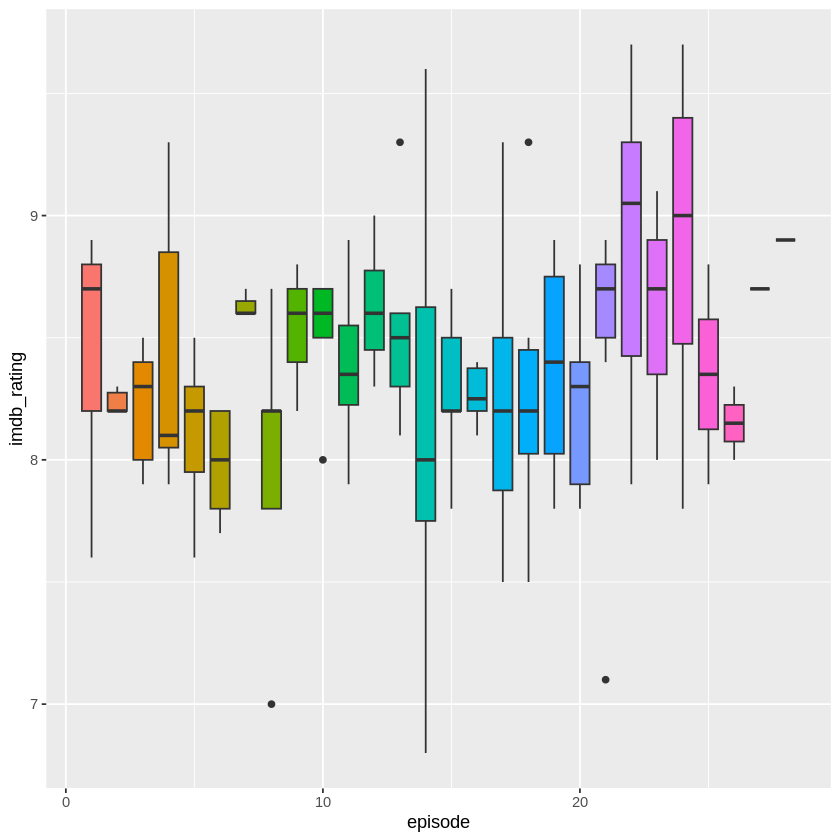

In [28]:
office %>%
  ggplot(aes(episode, imdb_rating, fill = as.factor(episode))) +
  geom_boxplot(show.legend = FALSE)

Ratings are higher for episodes later in the season. What else is associated with higher ratings? Let‚Äôs use lasso regression to find out! üöÄ

# Train a model

We can start by loading the tidymodels metapackage, and splitting our data into training and testing sets.

In [29]:
office_split <- initial_split(office, strata = season)
office_train <- training(office_split)
office_test <- testing(office_split)

Then, we build a recipe for data preprocessing.

- First, we must tell the recipe() what our model is going to be (using a formula here) and what our training data is.
- Next, we update the role for episode_name, since this is a variable we might like to keep around for convenience as an identifier for rows but is not a predictor or outcome.
- Next, we remove any numeric variables that have zero variance.
- As a last step, we normalize (center and scale) the numeric variables. We need to do this because it‚Äôs important for lasso regularization.

The object office_rec is a recipe that has not been trained on data yet (for example, the centered and scaling has not been calculated) and office_prep is an object that has been trained on data. The reason I use strings_as_factors = FALSE here is that my ID column episode_name is of type character (as opposed to, say, integers).

In [30]:
office_rec <- recipe(imdb_rating ~ ., data = office_train) %>%
  update_role(episode_name, new_role = "ID") %>%
  step_zv(all_numeric(), -all_outcomes()) %>%
  step_normalize(all_numeric(), -all_outcomes())

office_prep <- office_rec %>%
  prep(strings_as_factors = FALSE)

Now it‚Äôs time to specify and then fit our models. Here I set up one model specification for lasso regression; I picked a value for penalty (sort of randomly) and I set mixture = 1 for lasso. I am using a workflow() in this example for convenience; these are objects that can help you manage modeling pipelines more easily, with pieces that fit together like Lego blocks. You can fit() a workflow, much like you can fit a model, and then you can pull out the fit object and tidy() it!

In [39]:
lasso_spec <- linear_reg(penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet")

wf <- workflow() %>%
  add_recipe(office_rec)

lasso_fit <- wf %>%
  add_model(lasso_spec) %>%
  fit(data = office_train)

lasso_fit %>%
  pull_workflow_fit() %>%
  tidy()

Warning message:
‚Äú`pull_workflow_fit()` was deprecated in workflows 0.2.3.
‚Ñπ Please use `extract_fit_parsnip()` instead.‚Äù


term             estimate   penalty
1  (Intercept)      8.33500000 0.1    
2  season           0.00000000 0.1    
3  episode          0.00000000 0.1    
4  andy             0.00000000 0.1    
5  angela           0.00000000 0.1    
6  darryl           0.00000000 0.1    
7  dwight           0.00000000 0.1    
8  jim              0.06258487 0.1    
9  kelly            0.00000000 0.1    
10 kevin            0.00000000 0.1    
11 michael          0.09914356 0.1    
12 oscar            0.00000000 0.1    
13 pam              0.00000000 0.1    
14 phyllis          0.00000000 0.1    
15 ryan             0.00000000 0.1    
16 toby             0.00000000 0.1    
17 erin             0.00000000 0.1    
18 jan              0.00000000 0.1    
19 ken_kwapis       0.00000000 0.1    
20 greg_daniels     0.00000000 0.1    
21 b_j_novak        0.00000000 0.1    
22 paul_lieberstein 0.00000000 0.1    
23 mindy_kaling     0.00000000 0.1    
24 paul_feig        0.00000000 0.1    
25 gene_stupnitsky  0.00000000 0.1    
26 lee_eisenberg    0.00000000 0.1    
27 jennifer_celotta 0.00000000 0.1    
28 randall_einhorn  0.00000000 0.1    
29 brent_forrester  0.00000000 0.1    
30 jeffrey_blitz    0.00000000 0.1    
31 justin_spitzer   0.00000000 0.1

If you have used glmnet before, this is the familiar output where we can see (here, for the most regularized examples) what contributes to higher IMDB ratings.

# Tune LASSO parameters

So we fit one lasso model, but how do we know the right regularization parameter penalty? We can figure that out using resampling and tuning the model. Let‚Äôs build a set of bootstrap resamples, and set penalty = tune() instead of to a single value. We can use a function penalty() to set up an appropriate grid for this kind of regularization model.

In [40]:
set.seed(1234)
office_boot <- bootstraps(office_train, strata = season)

tune_spec <- linear_reg(penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

lambda_grid <- grid_regular(penalty(), levels = 50)

Now it‚Äôs time to tune the grid, using our workflow object.

In [41]:
doParallel::registerDoParallel()

set.seed(2020)
lasso_grid <- tune_grid(
  wf %>% add_model(tune_spec),
  resamples = office_boot,
  grid = lambda_grid
)

What results did we get?

In [42]:
lasso_grid %>%
  collect_metrics()

penalty      .metric .estimator mean        n  std_err    
1   1.000000e-10 rmse    standard   0.5980180   25 0.01656739 
2   1.000000e-10 rsq     standard   0.1230645   25 0.01715291 
3   1.599859e-10 rmse    standard   0.5980180   25 0.01656739 
4   1.599859e-10 rsq     standard   0.1230645   25 0.01715291 
5   2.559548e-10 rmse    standard   0.5980180   25 0.01656739 
6   2.559548e-10 rsq     standard   0.1230645   25 0.01715291 
7   4.094915e-10 rmse    standard   0.5980180   25 0.01656739 
8   4.094915e-10 rsq     standard   0.1230645   25 0.01715291 
9   6.551286e-10 rmse    standard   0.5980180   25 0.01656739 
10  6.551286e-10 rsq     standard   0.1230645   25 0.01715291 
11  1.048113e-09 rmse    standard   0.5980180   25 0.01656739 
12  1.048113e-09 rsq     standard   0.1230645   25 0.01715291 
13  1.676833e-09 rmse    standard   0.5980180   25 0.01656739 
14  1.676833e-09 rsq     standard   0.1230645   25 0.01715291 
15  2.682696e-09 rmse    standard   0.5980180   25 0.01656739 
16  2.682696e-09 rsq     standard   0.1230645   25 0.01715291 
17  4.291934e-09 rmse    standard   0.5980180   25 0.01656739 
18  4.291934e-09 rsq     standard   0.1230645   25 0.01715291 
19  6.866488e-09 rmse    standard   0.5980180   25 0.01656739 
20  6.866488e-09 rsq     standard   0.1230645   25 0.01715291 
21  1.098541e-08 rmse    standard   0.5980180   25 0.01656739 
22  1.098541e-08 rsq     standard   0.1230645   25 0.01715291 
23  1.757511e-08 rmse    standard   0.5980180   25 0.01656739 
24  1.757511e-08 rsq     standard   0.1230645   25 0.01715291 
25  2.811769e-08 rmse    standard   0.5980180   25 0.01656739 
26  2.811769e-08 rsq     standard   0.1230645   25 0.01715291 
27  4.498433e-08 rmse    standard   0.5980180   25 0.01656739 
28  4.498433e-08 rsq     standard   0.1230645   25 0.01715291 
29  7.196857e-08 rmse    standard   0.5980180   25 0.01656739 
30  7.196857e-08 rsq     standard   0.1230645   25 0.01715291 
‚ãÆ   ‚ãÆ            ‚ãÆ       ‚ãÆ          ‚ãÆ           ‚ãÆ  ‚ãÆ          
71  0.001389495  rmse    standard   0.587685505 25 0.015768713
72  0.001389495  rsq     standard   0.123352328 25 0.017327298
73  0.002222996  rmse    standard   0.580956673 25 0.015287630
74  0.002222996  rsq     standard   0.123728257 25 0.017474104
75  0.003556480  rmse    standard   0.571411159 25 0.014647547
76  0.003556480  rsq     standard   0.124158566 25 0.017552799
77  0.005689866  rmse    standard   0.558054380 25 0.013917949
78  0.005689866  rsq     standard   0.124888697 25 0.017692352
79  0.009102982  rmse    standard   0.541781569 25 0.013539164
80  0.009102982  rsq     standard   0.128099971 25 0.018020704
81  0.014563485  rmse    standard   0.524023420 25 0.013442138
82  0.014563485  rsq     standard   0.136408342 25 0.018982378
83  0.023299518  rmse    standard   0.506498981 25 0.013193019
84  0.023299518  rsq     standard   0.148543192 25 0.021348333
85  0.037275937  rmse    standard   0.495921695 25 0.013393312
86  0.037275937  rsq     standard   0.152069739 25 0.022893767
87  0.059636233  rmse    standard   0.496568861 25 0.013209550
88  0.059636233  rsq     standard   0.140001241 25 0.023410858
89  0.095409548  rmse    standard   0.496792778 25 0.011400759
90  0.095409548  rsq     standard   0.130167094 25 0.021130074
91  0.152641797  rmse    standard   0.500997576 25 0.009775754
92  0.152641797  rsq     standard   0.113401070 24 0.017093055
93  0.244205309  rmse    standard   0.512668845 25 0.009448717
94  0.244205309  rsq     standard   0.069781604  6 0.024627949
95  0.390693994  rmse    standard   0.512135353 25 0.010318555
96  0.390693994  rsq     standard   0.001895995  1          NA
97  0.625055193  rmse    standard   0.512009330 25 0.010379464
98  0.625055193  rsq     standard           NaN  0          NA
99  1.000000000  rmse    standard   0.512009330 25 0.010379464
100 1.000000000  rsq     standard           NaN  0          NA
    .config              
1   Preprocessor1_Model01
2   Preprocessor1_Model01
3   Pr

That‚Äôs nice, but I would rather see a visualization of performance with the regularization parameter.

Warning message:
‚ÄúUsing `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
‚Ñπ Please use `linewidth` instead.‚Äù
Warning message:
‚ÄúRemoved 2 rows containing missing values (`geom_line()`).‚Äù


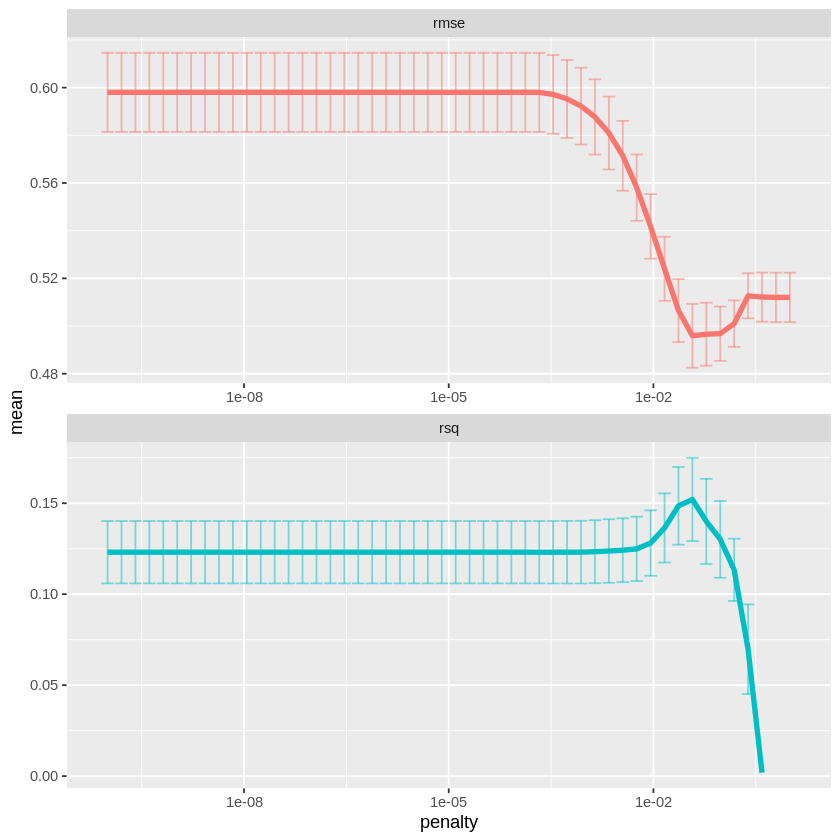

In [43]:
lasso_grid %>%
  collect_metrics() %>%
  ggplot(aes(penalty, mean, color = .metric)) +
  geom_errorbar(aes(
    ymin = mean - std_err,
    ymax = mean + std_err
  ),
  alpha = 0.5
  ) +
  geom_line(size = 1.5) +
  facet_wrap(~.metric, scales = "free", nrow = 2) +
  scale_x_log10() +
  theme(legend.position = "none")

This is a great way to see that regularization helps this modeling a lot. We have a couple of options for choosing our final parameter, such as select_by_pct_loss() or select_by_one_std_err(), but for now let‚Äôs stick with just picking the lowest RMSE. After we have that parameter, we can finalize our workflow, i.e. update it with this value.

In [44]:
lowest_rmse <- lasso_grid %>%
  select_best("rmse", maximize = FALSE)

final_lasso <- finalize_workflow(
  wf %>% add_model(tune_spec),
  lowest_rmse
)

Warning message:
‚ÄúThe `maximize` argument is no longer needed. This value was ignored.‚Äù


We can then fit this finalized workflow on our training data. While we‚Äôre at it, let‚Äôs see what the most important variables are using the vip package.

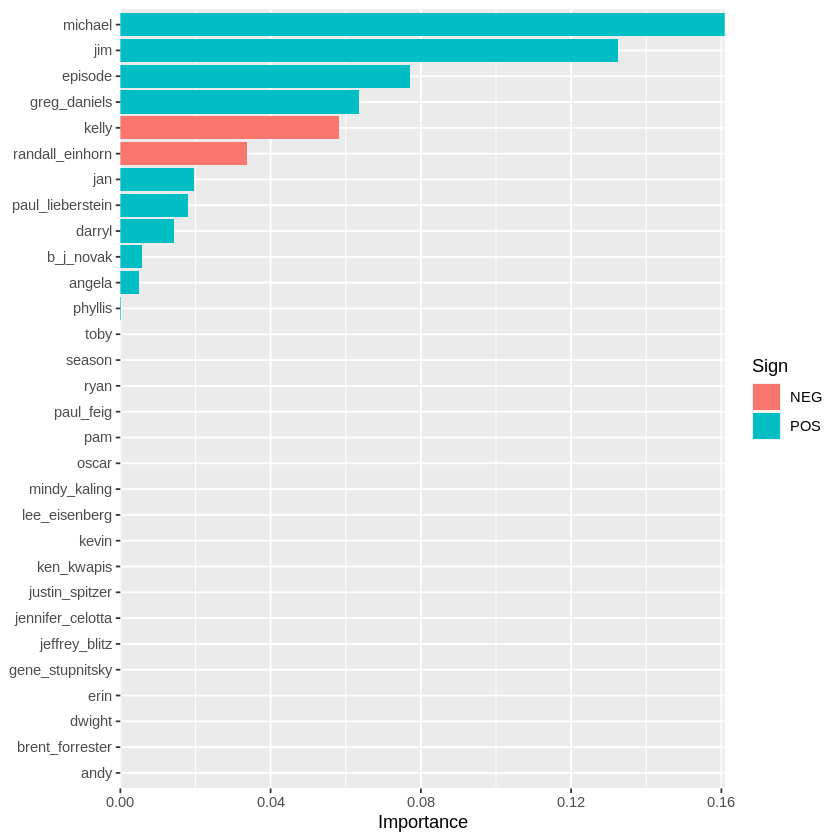

In [45]:
final_lasso %>%
  fit(office_train) %>%
  pull_workflow_fit() %>%
  vi(lambda = lowest_rmse$penalty) %>%
  mutate(
    Importance = abs(Importance),
    Variable = fct_reorder(Variable, Importance)
  ) %>%
  ggplot(aes(x = Importance, y = Variable, fill = Sign)) +
  geom_col() +
  scale_x_continuous(expand = c(0, 0)) +
  labs(y = NULL)

And then, finally, let‚Äôs return to our test data. The tune package has a function last_fit() which is nice for situations when you have tuned and finalized a model or workflow and want to fit it one last time on your training data and evaluate it on your testing data. You only have to pass this function your finalized model/workflow and your split.

In [46]:
last_fit(
  final_lasso,
  office_split
) %>%
  collect_metrics()

.metric .estimator .estimate .config             
1 rmse    standard   0.4235910 Preprocessor1_Model1
2 rsq     standard   0.2699494 Preprocessor1_Model1

For an example of tuning random forest, please see: https://juliasilge.com/blog/sf-trees-random-tuning/